# Rule-based classification of change events

This Jupyter Notebook demonstrates a rule-based classification workflow for analyzing change events. The notebook processes unlabelled change events, applies predefined classification rules, and generates labeled outputs. 

## Workflow

1. **Setup and Configuration**: 
    - Import necessary modules.
    - Set the working directory to ensure relative paths resolve correctly.

2. **Input/Output Paths**:
    - Define the path to the unlabelled change events file (`change_events_file`).
    - Specify the output folder (`outfolder`) and the path for the labeled output file (`labelled_file`).

3. **Classification Rules**:
    - Define a dictionary of rules (`classification_rules`) to classify events based on features such as `change_mean` and `hull_volume`.

4. **Processing**:
    - Load the unlabelled change events into a `ChangeEventCollection` object (`coll`).
    - Apply the rule-based classifier to generate a labeled DataFrame (`features_df`).
    - Save the labeled events to the specified output file.

5. **Visualization**:
    - Plot the classified events using scatter plots, with different colors representing different event types.

## Outputs
- **Labeled Events File**: A JSON file (`labelled_file`) containing the classified change events.
- **Visualization**: A scatter plot showing the distribution of classified events based on their features.

## Imports & working directory
In order to ensure all imports are available and that paths are relative to this script’s location, we first import modules and set the working directory.

In [1]:
import os
import matplotlib.pyplot as plt
from aimon import ProjectChange
from aimon import ChangeEventCollection
from aimon import utilities
import git

# Figure out the directory where this notebook/script lives
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

# Change into that directory so all relative paths resolve correctly
os.chdir(current_dir)

## Define input/output paths
Next we declare where to read our unlabelled events from, and where to write the labelled output.

In [2]:
# Path to the unlabelled change events test file
change_events_file = "../test_data/change_events_unlabelled.json"

# Folder where the labelled output will go
outfolder = "../test_data/out"

# Full path for the labelled file
labelled_file = os.path.join(outfolder, 'change_events_labelled_rule_based.json')

## Classification rules definition
To classify events by size or type, we define a dictionary of “rules.”
Each key is an event type and its value is a set of feature thresholds. <br><br>
"class_name": {
    "feature1": {"min": <lower_bound>, "max": <upper_bound>},
    "feature2": {"min": <lower_bound>}
}

In [3]:
classification_rules = {
    "large_change": {
         "change_mean": {"min": 0.2, "max": 10},
         "hull_volume": {"min": 100}
    },
    "small_change": {
         "change_mean": {"max": 0.2}
    },
    "specific_change": {
         "change_mean": {"min": 1, "max": 5},
         "hull_volume": {"min": 5, "max": 10}
    },
}

## Load, classify & save
With paths and rules in place, we load the unlabelled events, apply the rule‑based classifier, and save the results.

In [4]:
# Load events from file
coll = ChangeEventCollection().load_from_file(change_events_file)

# Apply our rule‑based classifier to produce a DataFrame of features + event_type
features_df = coll.classify_events_rule_based(classification_rules)

# Write the labelled events back out
coll.save_to_file(labelled_file)

## Visualize events clustering
Finally, we plot each class with a different color and use a log scale on the y‑axis to handle wide ranges of hull volumes.

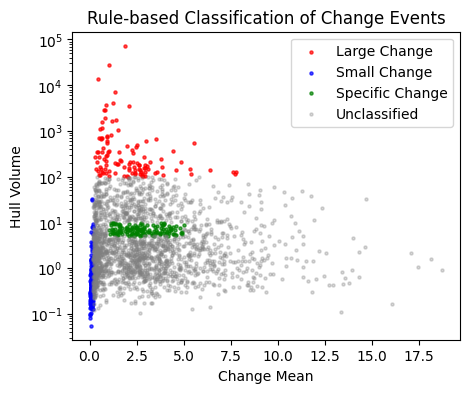

In [5]:
# Helper to plot a subset
def plot_events(df, event_type, color, alpha=0.7, size=5):
    subset = df[df['event_type'] == event_type]
    plt.scatter(subset['change_mean'], subset['hull_volume'],
                label=event_type.replace('_', ' ').title(),
                alpha=alpha, s=size, color=color)

plt.figure(figsize=(5, 4))

plot_events(features_df, 'large_change',   'red')
plot_events(features_df, 'small_change',   'blue')
plot_events(features_df, 'specific_change','green')
plot_events(features_df, 'unclassified',   'gray', alpha=0.3)

plt.yscale('log')
plt.legend()
plt.xlabel('Change Mean')
plt.ylabel('Hull Volume')
plt.title('Rule‑based Classification of Change Events')
plt.show()


## Project changes into GIS format
Finally, we wrap up by projecting our labelled events into GeoJSON using ProjectChange.

In [3]:
git_repo = git.Repo(current_dir, search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

img_path = os.path.join(git_root, "test_data/RangeImage.tif")
change_prj = ProjectChange(
    change_event_file       = labelled_file,
    project_name            = os.path.basename(labelled_file)[:-5],
    projected_image_path    = img_path,
    projected_events_folder = outfolder,
    epsg                    = 31254
)

change_prj.project_change()

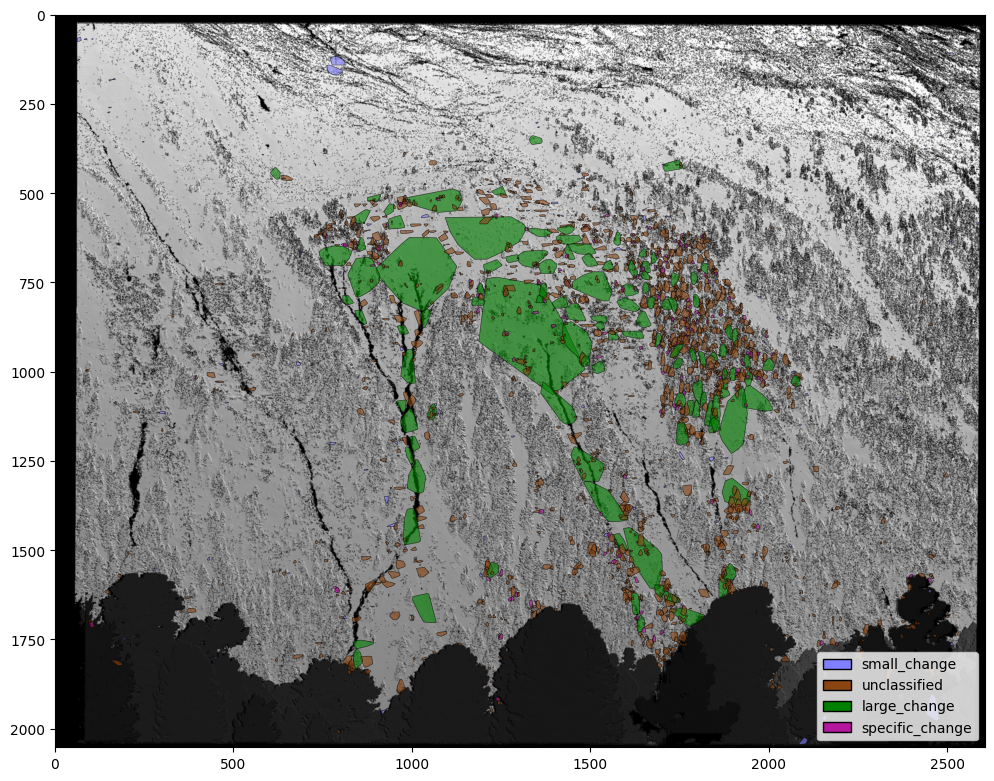

In [ ]:
# Paths to the vector and raster files
vector = "../test_data/out/change_events_labelled_rule_based_change_events_pixel.geojson"
raster = "../test_data/RangeImage.tif"

utilities.plot_change_events(vector, raster, 'event_type', ['#8080FF', '#8B4513', 'green', '#B5179E'])